In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

import json
import numpy as np
import pandas as pd
import torch

from constants import ( 
    MODEL_DIR,
    N_LEADS
)
from evaluate_script import read_data, predict
from resnet import ResNet1d

In [3]:
n_total = 10
# If a small array of traces IS already saved, read the np file
data_array = np.load('trace_file.npy')

# If a small array of traces IS NOT already saved, run the following line
# data_array, df, exam_ids = read_data(n_total=n_total, data_file='trace_file.npy')

In [4]:
data_array.shape[1:] == (4096, 12)

True

In [5]:
config = f'{MODEL_DIR}/config.json'
with open(config, 'r') as f:
    config_dict = json.load(f)

model = ResNet1d(
    input_dim=(N_LEADS, config_dict['seq_length']),
    blocks_dim=list(zip(config_dict['net_filter_size'], 
                        config_dict['net_seq_lengh'])),
    n_classes=1,
    kernel_size=config_dict['kernel_size'],
    dropout_rate=config_dict['dropout_rate']
)

In [6]:
# Loading the model weights in the model object
state_dict = (torch.load(
    '../model/model.pth',
    weights_only=False,
    map_location=torch.device('cpu')
))

In [7]:
weights_metadata = []
for key, val in state_dict['model'].items():
    weights_metadata.append([key, val.shape])
weights_metadata = pd.DataFrame(weights_metadata, columns=['layer_name', 'layer_shape'])
weights_metadata

,layer_name,layer_shape
0,conv1.weight,"(64, 12, 17)"
1,bn1.weight,"(64,)"
2,bn1.bias,"(64,)"
3,bn1.running_mean,"(64,)"
4,bn1.running_var,"(64,)"
...,...,...
67,resblock1d_4.bn2.running_var,"(320,)"
68,resblock1d_4.bn2.num_batches_tracked,()
69,resblock1d_4.skip_connection.1.weight,"(320, 256, 1)"
70,lin.weight,"(1, 5120)"


In [9]:
weights_metadata.head(25)

,layer_name,layer_shape
0,conv1.weight,"(64, 12, 17)"
1,bn1.weight,"(64,)"
2,bn1.bias,"(64,)"
3,bn1.running_mean,"(64,)"
4,bn1.running_var,"(64,)"
5,bn1.num_batches_tracked,()
6,resblock1d_0.conv1.weight,"(64, 64, 17)"
7,resblock1d_0.bn1.weight,"(64,)"
8,resblock1d_0.bn1.bias,"(64,)"
9,resblock1d_0.bn1.running_mean,"(64,)"


In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load the state dict and set the model to eval mode.
model.load_state_dict(state_dict['model'])
type(model)

resnet.ResNet1d

In [10]:
hidden_outputs = {}

def save_output(name):
    def hook(module, inp, out):
        hidden_outputs[name] = out.detach().cpu()
    return hook

In [11]:
# Hook for initial layers
model.conv1.register_forward_hook(save_output("conv1"))
model.bn1.register_forward_hook(save_output("bn1"))

# Hooks for each ResBlock1d
for i, blk in enumerate(model.res_blocks):
    blk.conv1.register_forward_hook(save_output(f"block{i}_conv1"))
    blk.bn1.register_forward_hook(save_output(f"block{i}_bn1"))
    blk.conv2.register_forward_hook(save_output(f"block{i}_conv2"))
    blk.bn2.register_forward_hook(save_output(f"block{i}_bn2"))


In [12]:
out = model(torch.from_numpy(data_array).transpose(-1, -2))

In [13]:
layer0 = hidden_outputs["block0_conv1"]
print(layer0.shape)

torch.Size([10, 64, 4096])


In [14]:
hidden_outputs_metadata = []
for key, val in hidden_outputs.items():
    hidden_outputs_metadata.append([key, val.shape])
hidden_outputs_metadata = pd.DataFrame(hidden_outputs_metadata, columns=['layer_name', 'layer_shape'])
hidden_outputs_metadata

,layer_name,layer_shape
0,conv1,"(10, 64, 4096)"
1,bn1,"(10, 64, 4096)"
2,block0_conv1,"(10, 64, 4096)"
3,block0_bn1,"(10, 64, 4096)"
4,block0_conv2,"(10, 64, 4096)"
5,block0_bn2,"(10, 64, 4096)"
6,block1_conv1,"(10, 128, 4096)"
7,block1_bn1,"(10, 128, 4096)"
8,block1_conv2,"(10, 128, 1024)"
9,block1_bn2,"(10, 128, 1024)"


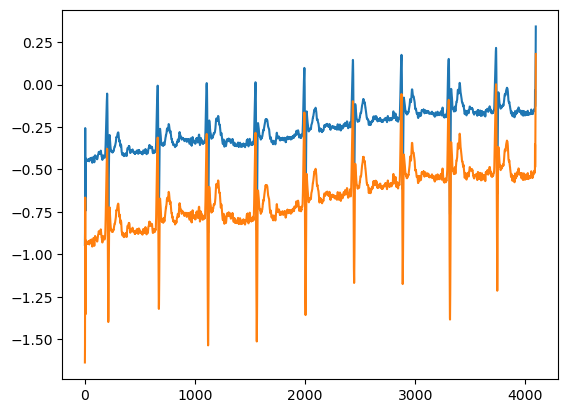

In [21]:
import matplotlib.pyplot as plt
plt.plot(hidden_outputs['conv1'][0, 23, :])
plt.plot(hidden_outputs['bn1'][0, 23, :])


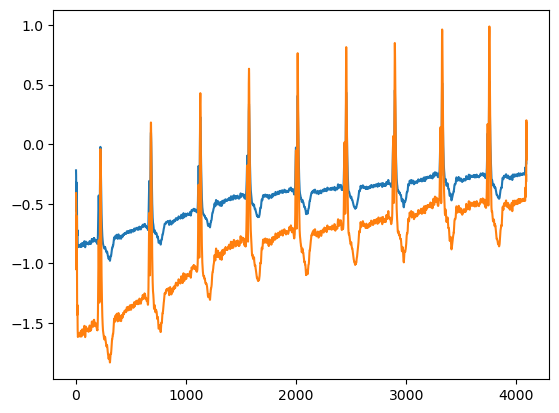

In [22]:
plt.plot(hidden_outputs['block0_conv1'][0, 23, :])
plt.plot(hidden_outputs['block0_bn1'][0, 23, :])

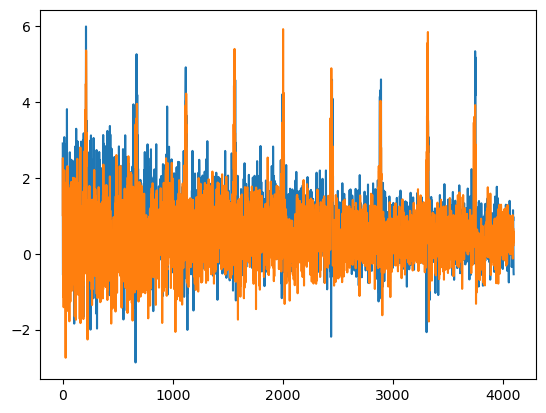

In [25]:
plt.plot(hidden_outputs['block0_conv2'][0, 3, :])
plt.plot(hidden_outputs['block0_conv2'][0, 13, :])
# plt.plot(hidden_outputs['block0_bn2'][0, 23, :])

In [26]:
# Hook for initial layers
model.conv1.register_module_forward_hook(save_output("conv1"))
model.bn1.register_module_forward_hook(save_output("bn1"))

# Hooks for each ResBlock1d
for i, blk in enumerate(model.res_blocks):
    blk.conv1.register_module_forward_hook(save_output(f"block{i}_conv1"))
    blk.bn1.register_module_forward_hook(save_output(f"block{i}_bn1"))
    blk.conv2.register_module_forward_hook(save_output(f"block{i}_conv2"))
    blk.bn2.register_module_forward_hook(save_output(f"block{i}_bn2"))
out = model(torch.from_numpy(data_array).transpose(-1, -2))

layer0 = hidden_outputs["block0_conv1"]
print(layer0.shape)

AttributeError: 'Conv1d' object has no attribute 'register_module_forward_hook'

In [27]:
dir(blk.conv1)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__constants__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__firstlineno__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__static_attributes__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_backward_pre_hooks',
 '_buffers',
 '_call_impl',
 '_compiled_call_impl',
 '_conv_forward',
 '_forward_hooks',
 '_forward_hooks_always_called',
 '_forward_hooks_with_kwargs',
 '_forward_pre_hooks',
 '_forward_pre_hooks_with_kwargs',
 '_get_backward_hooks',
 '_get_backward_pre_hooks',
 '_get_name',
 '_is_full_backward_hook',
 '_load_from_state_dict',
 '_load_state_dict_post_hooks',
 '_load_state_dict_pre_hooks',
 '_maybe_warn_non

In [29]:
blk.conv1.register_forward_hook?

Signature:
blk.conv1.register_forward_hook(
    hook: Union[Callable[[~T, tuple[Any, ...], Any], Optional[Any]], Callable[[~T, tuple[Any, ...], dict[str, Any], Any], Optional[Any]]],
    *,
    prepend: bool = False,
    with_kwargs: bool = False,
    always_call: bool = False,
) -> torch.utils.hooks.RemovableHandle
Docstring:
Register a forward hook on the module.

The hook will be called every time after :func:`forward` has computed an output.

If ``with_kwargs`` is ``False`` or not specified, the input contains only
the positional arguments given to the module. Keyword arguments won't be
passed to the hooks and only to the ``forward``. The hook can modify the
output. It can modify the input inplace but it will not have effect on
forward since this is called after :func:`forward` is called. The hook
should have the following signature::

    hook(module, args, output) -> None or modified output

If ``with_kwargs`` is ``True``, the forward hook will be passed the
``kwargs`` given to t